# **Deforum Stable Diffusion v0.4**
[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings). You need to get the ckpt file and put it on your Google Drive first to use this. It can be downloaded from [HuggingFace](https://huggingface.co/CompVis/stable-diffusion).

Notebook by [deforum](https://discord.gg/upmXXsrwZc)

### Prompts
`animation_mode: None` batches on list of *prompts*. `animation_mode: 2D` uses *animation_prompts* key frame sequence

In [1]:
prompts = [
    "a terrier dog laying on a green couch, simple line drawing in crosshatch style."
    #"an open palm with an eye in the middle, painted, in tarot and astrology style, simple  line drawing with crosshatching."
    #"Jennifer Aniston in anime style, hannah barbera"
    #"A black and white one-eyed terrier dog named pontchartrain"
    #"Painting of a cat astronaut's head, just its head, on a starry space background.",
    #"An orange nautical tabby cat wearing an admiral's hat, in portrait style, with the ocean in the background, seagulls flying, joseph severin, oil painting from the early 1800s",
    #"continuous line drawing of a three legged cat, in blind contour style."
    #"a beautiful forest by Asher Brown Durand, trending on Artstation", #the first prompt I want
    #"a beautiful portrait of a Jennifer Aniston by Artgerm, trending on Artstation, photorealistic, 8k, hyper-realism", #the second prompt I want
    #"the third prompt I don't want it I commented it with an",
]

animation_prompts = {
    0: "a beautiful apple, trending on Artstation",
    10: "a beautiful banana, trending on Artstation",
    100: "a beautiful coconut, trending on Artstation",
    101: "a beautiful durian, trending on Artstation",
}

In [2]:
#@markdown **Model and Output Paths**
# ask for the link
print("Local Path Variables:\n")

models_path = "/workspace/mnt/models" #@param {type:"string"}
output_path = "/workspace/mnt/output" #@param {type:"string"}

#@markdown **Google Drive Path Variables (Optional)**
mount_google_drive = False #@param {type:"boolean"}
force_remount = False

if mount_google_drive:
    from google.colab import drive # type: ignore
    try:
        drive_path = "/content/drive"
        drive.mount(drive_path,force_remount=force_remount)
        models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
        output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
        models_path = models_path_gdrive
        output_path = output_path_gdrive
    except:
        print("...error mounting drive or with drive path variables")
        print("...reverting to default path variables")

import os
os.makedirs(models_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

print(f"models_path: {models_path}")
print(f"output_path: {output_path}")

Local Path Variables:

models_path: /workspace/mnt/models
output_path: /workspace/mnt/output


In [3]:
#@markdown **Python Definitions**
import json
from IPython import display

import gc, math, os, pathlib, subprocess, sys, time
import cv2
import numpy as np
import pandas as pd
import random
import requests
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from skimage.exposure import match_histograms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from types import SimpleNamespace
from torch import autocast

sys.path.extend([
    '/workspace/stable-diffusion',
    '/workspace/stable-diffusion/pytorch3d-lite',
    '/workspace/stable-diffusion/AdaBins',
    '/workspace/stable-diffusion/MiDaS',
])

import py3d_tools as p3d

from helpers import DepthModel, sampler_fn
from k_diffusion.external import CompVisDenoiser
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

def sanitize(prompt):
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    tmp = ''.join(filter(whitelist.__contains__, prompt))
    return tmp.replace(' ', '_')

def anim_frame_warp_2d(prev_img_cv2, args, anim_args, keys, frame_idx):
    angle = keys.angle_series[frame_idx]
    zoom = keys.zoom_series[frame_idx]
    translation_x = keys.translation_x_series[frame_idx]
    translation_y = keys.translation_y_series[frame_idx]

    center = (args.W // 2, args.H // 2)
    trans_mat = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    rot_mat = cv2.getRotationMatrix2D(center, angle, zoom)
    trans_mat = np.vstack([trans_mat, [0,0,1]])
    rot_mat = np.vstack([rot_mat, [0,0,1]])
    xform = np.matmul(rot_mat, trans_mat)

    return cv2.warpPerspective(
        prev_img_cv2,
        xform,
        (prev_img_cv2.shape[1], prev_img_cv2.shape[0]),
        borderMode=cv2.BORDER_WRAP if anim_args.border == 'wrap' else cv2.BORDER_REPLICATE
    )

def anim_frame_warp_3d(prev_img_cv2, depth, anim_args, keys, frame_idx):
    TRANSLATION_SCALE = 1.0/200.0 # matches Disco
    translate_xyz = [
        -keys.translation_x_series[frame_idx] * TRANSLATION_SCALE, 
        keys.translation_y_series[frame_idx] * TRANSLATION_SCALE, 
        -keys.translation_z_series[frame_idx] * TRANSLATION_SCALE
    ]
    rotate_xyz = [
        math.radians(keys.rotation_3d_x_series[frame_idx]), 
        math.radians(keys.rotation_3d_y_series[frame_idx]), 
        math.radians(keys.rotation_3d_z_series[frame_idx])
    ]
    rot_mat = p3d.euler_angles_to_matrix(torch.tensor(rotate_xyz, device=device), "XYZ").unsqueeze(0)
    result = transform_image_3d(prev_img_cv2, depth, rot_mat, translate_xyz, anim_args)
    torch.cuda.empty_cache()
    return result

def add_noise(sample: torch.Tensor, noise_amt: float) -> torch.Tensor:
    return sample + torch.randn(sample.shape, device=sample.device) * noise_amt

def get_output_folder(output_path, batch_folder):
    out_path = os.path.join(output_path,time.strftime('%Y-%m'))
    if batch_folder != "":
        out_path = os.path.join(out_path, batch_folder)
    os.makedirs(out_path, exist_ok=True)
    return out_path

def load_img(path, shape, use_alpha_as_mask=False):
    # use_alpha_as_mask: Read the alpha channel of the image as the mask image
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw)
    else:
        image = Image.open(path)

    if use_alpha_as_mask:
        image = image.convert('RGBA')
    else:
        image = image.convert('RGB')

    image = image.resize(shape, resample=Image.LANCZOS)

    mask_image = None
    if use_alpha_as_mask:
      # Split alpha channel into a mask_image
      red, green, blue, alpha = Image.Image.split(image)
      mask_image = alpha.convert('L')
      image = image.convert('RGB')

    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    image = 2.*image - 1.

    return image, mask_image

def load_mask_latent(mask_input, shape):
    # mask_input (str or PIL Image.Image): Path to the mask image or a PIL Image object
    # shape (list-like len(4)): shape of the image to match, usually latent_image.shape
    
    if isinstance(mask_input, str): # mask input is probably a file name
        if mask_input.startswith('http://') or mask_input.startswith('https://'):
            mask_image = Image.open(requests.get(mask_input, stream=True).raw).convert('RGBA')
        else:
            mask_image = Image.open(mask_input).convert('RGBA')
    elif isinstance(mask_input, Image.Image):
        mask_image = mask_input
    else:
        raise Exception("mask_input must be a PIL image or a file name")

    mask_w_h = (shape[-1], shape[-2])
    mask = mask_image.resize(mask_w_h, resample=Image.LANCZOS)
    mask = mask.convert("L")
    return mask

def prepare_mask(mask_input, mask_shape, mask_brightness_adjust=1.0, mask_contrast_adjust=1.0):
    # mask_input (str or PIL Image.Image): Path to the mask image or a PIL Image object
    # shape (list-like len(4)): shape of the image to match, usually latent_image.shape
    # mask_brightness_adjust (non-negative float): amount to adjust brightness of the iamge, 
    #     0 is black, 1 is no adjustment, >1 is brighter
    # mask_contrast_adjust (non-negative float): amount to adjust contrast of the image, 
    #     0 is a flat grey image, 1 is no adjustment, >1 is more contrast
    
    mask = load_mask_latent(mask_input, mask_shape)

    # Mask brightness/contrast adjustments
    if mask_brightness_adjust != 1:
        mask = TF.adjust_brightness(mask, mask_brightness_adjust)
    if mask_contrast_adjust != 1:
        mask = TF.adjust_contrast(mask, mask_contrast_adjust)

    # Mask image to array
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = np.tile(mask,(4,1,1))
    mask = np.expand_dims(mask,axis=0)
    mask = torch.from_numpy(mask)

    if args.invert_mask:
        mask = ( (mask - 0.5) * -1) + 0.5
    
    mask = np.clip(mask,0,1)
    return mask

def maintain_colors(prev_img, color_match_sample, mode):
    if mode == 'Match Frame 0 RGB':
        return match_histograms(prev_img, color_match_sample, multichannel=True)
    elif mode == 'Match Frame 0 HSV':
        prev_img_hsv = cv2.cvtColor(prev_img, cv2.COLOR_RGB2HSV)
        color_match_hsv = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2HSV)
        matched_hsv = match_histograms(prev_img_hsv, color_match_hsv, multichannel=True)
        return cv2.cvtColor(matched_hsv, cv2.COLOR_HSV2RGB)
    else: # Match Frame 0 LAB
        prev_img_lab = cv2.cvtColor(prev_img, cv2.COLOR_RGB2LAB)
        color_match_lab = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2LAB)
        matched_lab = match_histograms(prev_img_lab, color_match_lab, multichannel=True)
        return cv2.cvtColor(matched_lab, cv2.COLOR_LAB2RGB)


def make_callback(sampler_name, dynamic_threshold=None, static_threshold=None, mask=None, init_latent=None, sigmas=None, sampler=None, masked_noise_modifier=1.0):  
    # Creates the callback function to be passed into the samplers
    # The callback function is applied to the image at each step
    def dynamic_thresholding_(img, threshold):
        # Dynamic thresholding from Imagen paper (May 2022)
        s = np.percentile(np.abs(img.cpu()), threshold, axis=tuple(range(1,img.ndim)))
        s = np.max(np.append(s,1.0))
        torch.clamp_(img, -1*s, s)
        torch.FloatTensor.div_(img, s)

    # Callback for samplers in the k-diffusion repo, called thus:
    #   callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigmas[i], 'denoised': denoised})
    def k_callback_(args_dict):
        if dynamic_threshold is not None:
            dynamic_thresholding_(args_dict['x'], dynamic_threshold)
        if static_threshold is not None:
            torch.clamp_(args_dict['x'], -1*static_threshold, static_threshold)
        if mask is not None:
            init_noise = init_latent + noise * args_dict['sigma']
            is_masked = torch.logical_and(mask >= mask_schedule[args_dict['i']], mask != 0 )
            new_img = init_noise * torch.where(is_masked,1,0) + args_dict['x'] * torch.where(is_masked,0,1)
            args_dict['x'].copy_(new_img)

    # Function that is called on the image (img) and step (i) at each step
    def img_callback_(img, i):
        # Thresholding functions
        if dynamic_threshold is not None:
            dynamic_thresholding_(img, dynamic_threshold)
        if static_threshold is not None:
            torch.clamp_(img, -1*static_threshold, static_threshold)
        if mask is not None:
            i_inv = len(sigmas) - i - 1
            init_noise = sampler.stochastic_encode(init_latent, torch.tensor([i_inv]*batch_size).to(device), noise=noise)
            is_masked = torch.logical_and(mask >= mask_schedule[i], mask != 0 )
            new_img = init_noise * torch.where(is_masked,1,0) + img * torch.where(is_masked,0,1)
            img.copy_(new_img)
              
    if init_latent is not None:
        noise = torch.randn_like(init_latent, device=device) * masked_noise_modifier
    if sigmas is not None and len(sigmas) > 0:
        mask_schedule, _ = torch.sort(sigmas/torch.max(sigmas))
    elif len(sigmas) == 0:
        mask = None # no mask needed if no steps (usually happens because strength==1.0)
    if sampler_name in ["plms","ddim"]: 
        # Callback function formated for compvis latent diffusion samplers
        if mask is not None:
            assert sampler is not None, "Callback function for stable-diffusion samplers requires sampler variable"
            batch_size = init_latent.shape[0]

        callback = img_callback_
    else: 
        # Default callback function uses k-diffusion sampler variables
        callback = k_callback_

    return callback

def sample_from_cv2(sample: np.ndarray) -> torch.Tensor:
    sample = ((sample.astype(float) / 255.0) * 2) - 1
    sample = sample[None].transpose(0, 3, 1, 2).astype(np.float16)
    sample = torch.from_numpy(sample)
    return sample

def sample_to_cv2(sample: torch.Tensor, type=np.uint8) -> np.ndarray:
    sample_f32 = rearrange(sample.squeeze().cpu().numpy(), "c h w -> h w c").astype(np.float32)
    sample_f32 = ((sample_f32 * 0.5) + 0.5).clip(0, 1)
    sample_int8 = (sample_f32 * 255)
    return sample_int8.astype(type)

def transform_image_3d(prev_img_cv2, depth_tensor, rot_mat, translate, anim_args):
    # adapted and optimized version of transform_image_3d from Disco Diffusion https://github.com/alembics/disco-diffusion 
    w, h = prev_img_cv2.shape[1], prev_img_cv2.shape[0]

    aspect_ratio = float(w)/float(h)
    near, far, fov_deg = anim_args.near_plane, anim_args.far_plane, anim_args.fov
    persp_cam_old = p3d.FoVPerspectiveCameras(near, far, aspect_ratio, fov=fov_deg, degrees=True, device=device)
    persp_cam_new = p3d.FoVPerspectiveCameras(near, far, aspect_ratio, fov=fov_deg, degrees=True, R=rot_mat, T=torch.tensor([translate]), device=device)

    # range of [-1,1] is important to torch grid_sample's padding handling
    y,x = torch.meshgrid(torch.linspace(-1.,1.,h,dtype=torch.float32,device=device),torch.linspace(-1.,1.,w,dtype=torch.float32,device=device))
    z = torch.as_tensor(depth_tensor, dtype=torch.float32, device=device)
    xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)

    xyz_old_cam_xy = persp_cam_old.get_full_projection_transform().transform_points(xyz_old_world)[:,0:2]
    xyz_new_cam_xy = persp_cam_new.get_full_projection_transform().transform_points(xyz_old_world)[:,0:2]

    offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
    # affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
    identity_2d_batch = torch.tensor([[1.,0.,0.],[0.,1.,0.]], device=device).unsqueeze(0)
    # coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
    coords_2d = torch.nn.functional.affine_grid(identity_2d_batch, [1,1,h,w], align_corners=False)
    offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h,w,2)).unsqueeze(0)

    image_tensor = rearrange(torch.from_numpy(prev_img_cv2.astype(np.float32)), 'h w c -> c h w').to(device)
    new_image = torch.nn.functional.grid_sample(
        image_tensor.add(1/512 - 0.0001).unsqueeze(0), 
        offset_coords_2d, 
        mode=anim_args.sampling_mode, 
        padding_mode=anim_args.padding_mode, 
        align_corners=False
    )

    # convert back to cv2 style numpy array
    result = rearrange(
        new_image.squeeze().clamp(0,255), 
        'c h w -> h w c'
    ).cpu().numpy().astype(prev_img_cv2.dtype)
    return result

def generate(args, return_latent=False, return_sample=False, return_c=False):
    seed_everything(args.seed)
    os.makedirs(args.outdir, exist_ok=True)

    sampler = PLMSSampler(model) if args.sampler == 'plms' else DDIMSampler(model)
    model_wrap = CompVisDenoiser(model)
    batch_size = args.n_samples
    prompt = args.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]
    precision_scope = autocast if args.precision == "autocast" else nullcontext

    init_latent = None
    mask_image = None
    init_image = None
    if args.init_latent is not None:
        init_latent = args.init_latent
    elif args.init_sample is not None:
        with precision_scope("cuda"):
            init_latent = model.get_first_stage_encoding(model.encode_first_stage(args.init_sample))
    elif args.use_init and args.init_image != None and args.init_image != '':
        init_image, mask_image = load_img(args.init_image, 
                                          shape=(args.W, args.H),  
                                          use_alpha_as_mask=args.use_alpha_as_mask)
        init_image = init_image.to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        with precision_scope("cuda"):
            init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space        

    if not args.use_init and args.strength > 0 and args.strength_0_no_init:
        print("\nNo init image, but strength > 0. Strength has been auto set to 0, since use_init is False.")
        print("If you want to force strength > 0 with no init, please set strength_0_no_init to False.\n")
        args.strength = 0

    # Mask functions
    if args.use_mask:
        assert args.mask_file is not None or mask_image is not None, "use_mask==True: An mask image is required for a mask. Please enter a mask_file or use an init image with an alpha channel"
        assert args.use_init, "use_mask==True: use_init is required for a mask"
        assert init_latent is not None, "use_mask==True: An latent init image is required for a mask"

        mask = prepare_mask(args.mask_file if mask_image is None else mask_image, 
                            init_latent.shape, 
                            args.mask_contrast_adjust, 
                            args.mask_brightness_adjust)
        
        if (torch.all(mask == 0) or torch.all(mask == 1)) and args.use_alpha_as_mask:
            raise Warning("use_alpha_as_mask==True: Using the alpha channel from the init image as a mask, but the alpha channel is blank.")
        
        mask = mask.to(device)
        mask = repeat(mask, '1 ... -> b ...', b=batch_size)
    else:
        mask = None
        
    t_enc = int((1.0-args.strength) * args.steps)

    # Noise schedule for the k-diffusion samplers (used for masking)
    k_sigmas = model_wrap.get_sigmas(args.steps)
    k_sigmas = k_sigmas[len(k_sigmas)-t_enc-1:]

    if args.sampler in ['plms','ddim']:
        sampler.make_schedule(ddim_num_steps=args.steps, ddim_eta=args.ddim_eta, ddim_discretize='fill', verbose=False)

    callback = make_callback(sampler_name=args.sampler,
                            dynamic_threshold=args.dynamic_threshold, 
                            static_threshold=args.static_threshold,
                            mask=mask, 
                            init_latent=init_latent,
                            sigmas=k_sigmas,
                            sampler=sampler)    

    results = []
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for prompts in data:
                    uc = None
                    if args.scale != 1.0:
                        uc = model.get_learned_conditioning(batch_size * [""])
                    if isinstance(prompts, tuple):
                        prompts = list(prompts)
                    c = model.get_learned_conditioning(prompts)

                    if args.init_c != None:
                        c = args.init_c

                    if args.sampler in ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral"]:
                        samples = sampler_fn(
                            c=c, 
                            uc=uc, 
                            args=args, 
                            model_wrap=model_wrap, 
                            init_latent=init_latent, 
                            t_enc=t_enc, 
                            device=device, 
                            cb=callback)
                    else:
                        # args.sampler == 'plms' or args.sampler == 'ddim':
                        if init_latent is not None and args.strength > 0:
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                        else:
                            z_enc = torch.randn([args.n_samples, args.C, args.H // args.f, args.W // args.f], device=device)
                        if args.sampler == 'ddim':
                            samples = sampler.decode(z_enc, 
                                                     c, 
                                                     t_enc, 
                                                     unconditional_guidance_scale=args.scale,
                                                     unconditional_conditioning=uc,
                                                     img_callback=callback)
                        elif args.sampler == 'plms': # no "decode" function in plms, so use "sample"
                            shape = [args.C, args.H // args.f, args.W // args.f]
                            samples, _ = sampler.sample(S=args.steps,
                                                            conditioning=c,
                                                            batch_size=args.n_samples,
                                                            shape=shape,
                                                            verbose=False,
                                                            unconditional_guidance_scale=args.scale,
                                                            unconditional_conditioning=uc,
                                                            eta=args.ddim_eta,
                                                            x_T=z_enc,
                                                            img_callback=callback)
                        else:
                            raise Exception(f"Sampler {args.sampler} not recognised.")

                    if return_latent:
                        results.append(samples.clone())

                    x_samples = model.decode_first_stage(samples)
                    if return_sample:
                        results.append(x_samples.clone())

                    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                    if return_c:
                        results.append(c.clone())

                    for x_sample in x_samples:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        image = Image.fromarray(x_sample.astype(np.uint8))
                        results.append(image)
    return results

In [4]:
#@markdown **Select and Load Model**

model_config = "v1-inference.yaml" #@param ["custom","v1-inference.yaml"]
model_checkpoint =  "sd-v1-4.ckpt" #@param ["custom","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt"]
custom_config_path = "" #@param {type:"string"}
custom_checkpoint_path = "" #@param {type:"string"}

load_on_run_all = True #@param {type: 'boolean'}
half_precision = True # check
check_sha256 = True #@param {type:"boolean"}

model_map = {
    "sd-v1-4-full-ema.ckpt": {'sha256': '14749efc0ae8ef0329391ad4436feb781b402f4fece4883c7ad8d10556d8a36a'},
    "sd-v1-4.ckpt": {'sha256': 'fe4efff1e174c627256e44ec2991ba279b3816e364b49f9be2abc0b3ff3f8556'},
    "sd-v1-3-full-ema.ckpt": {'sha256': '54632c6e8a36eecae65e36cb0595fab314e1a1545a65209f24fde221a8d4b2ca'},
    "sd-v1-3.ckpt": {'sha256': '2cff93af4dcc07c3e03110205988ff98481e86539c51a8098d4f2236e41f7f2f'},
    "sd-v1-2-full-ema.ckpt": {'sha256': 'bc5086a904d7b9d13d2a7bccf38f089824755be7261c7399d92e555e1e9ac69a'},
    "sd-v1-2.ckpt": {'sha256': '3b87d30facd5bafca1cbed71cfb86648aad75d1c264663c0cc78c7aea8daec0d'},
    "sd-v1-1-full-ema.ckpt": {'sha256': 'efdeb5dc418a025d9a8cc0a8617e106c69044bc2925abecc8a254b2910d69829'},
    "sd-v1-1.ckpt": {'sha256': '86cd1d3ccb044d7ba8db743d717c9bac603c4043508ad2571383f954390f3cea'}
}

# config path
ckpt_config_path = custom_config_path if model_config == "custom" else os.path.join(models_path, model_config)
if os.path.exists(ckpt_config_path):
    print(f"{ckpt_config_path} exists")
else:
    ckpt_config_path = "./stable-diffusion/configs/stable-diffusion/v1-inference.yaml"
print(f"Using config: {ckpt_config_path}")

# checkpoint path or download
ckpt_path = custom_checkpoint_path if model_checkpoint == "custom" else os.path.join(models_path, model_checkpoint)
ckpt_valid = True
if os.path.exists(ckpt_path):
    print(f"{ckpt_path} exists")
else:
    print(f"Please download model checkpoint and place in {os.path.join(models_path, model_checkpoint)}")
    ckpt_valid = False

if check_sha256 and model_checkpoint != "custom" and ckpt_valid:
    import hashlib
    print("\n...checking sha256")
    with open(ckpt_path, "rb") as f:
        bytes = f.read() 
        hash = hashlib.sha256(bytes).hexdigest()
        del bytes
    if model_map[model_checkpoint]["sha256"] == hash:
        print("hash is correct\n")
    else:
        print("hash in not correct\n")
        ckpt_valid = False

if ckpt_valid:
    print(f"Using ckpt: {ckpt_path}")

def load_model_from_config(config, ckpt, verbose=False, device='cuda', half_precision=True):
    map_location = "cuda" #@param ["cpu", "cuda"]
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=map_location)
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    if half_precision:
        model = model.half().to(device)
    else:
        model = model.to(device)
    model.eval()
    return model

if load_on_run_all and ckpt_valid:
    local_config = OmegaConf.load(f"{ckpt_config_path}")
    model = load_model_from_config(local_config, f"{ckpt_path}", half_precision=half_precision)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)

/workspace/mnt/models/v1-inference.yaml exists
Using config: /workspace/mnt/models/v1-inference.yaml
/workspace/mnt/models/sd-v1-4.ckpt exists

...checking sha256
hash is correct

Using ckpt: /workspace/mnt/models/sd-v1-4.ckpt
Loading model from /workspace/mnt/models/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.16.self_attn.v_proj.bias', 'vision_model.encoder.layers.23.mlp.fc2.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.15.self_attn.k_proj.bias', 'vision_model.encoder.layers.21.self_attn.out_proj.weight', 'vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.17.mlp.fc1.weight', 'vision_model.encoder.layers.15.self_attn.v_proj.bias', 'vision_model.embeddings.class_embedding', 'vision_model.encoder.layers.6.mlp.fc1.weight', 'vision_model.encoder.layers.23.layer_norm1.bias', 'vision_model.encoder.layers.10.layer_norm2.weight', 'vision_model.encoder.layers.12.layer_norm2.bias', 'vision_model.encoder.layers.12.layer_norm1.bias', 'vision_model.encoder.layers.7.mlp.fc1.weight', 'vision_model.encoder.layers.18.layer_norm2.bias', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', '

# Settings

### Animation Settings

In [5]:

def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = 'None' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 1000 #@param {type:"number"}
    border = 'wrap' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(1.04)"#@param {type:"string"}
    translation_x = "0:(0)"#@param {type:"string"}
    translation_y = "0:(0)"#@param {type:"string"}
    translation_z = "0:(10)"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0:(0)"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    noise_schedule = "0: (0.02)"#@param {type:"string"}
    strength_schedule = "0: (0.65)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB'] {type:'string'}
    diffusion_cadence = '1' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 4 #@param {type:"number"}
    
    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20220829210106" #@param {type:"string"}

    return locals()

class DeformAnimKeys():
    def __init__(self, anim_args):
        self.angle_series = get_inbetweens(parse_key_frames(anim_args.angle), anim_args.max_frames)
        self.zoom_series = get_inbetweens(parse_key_frames(anim_args.zoom), anim_args.max_frames)
        self.translation_x_series = get_inbetweens(parse_key_frames(anim_args.translation_x), anim_args.max_frames)
        self.translation_y_series = get_inbetweens(parse_key_frames(anim_args.translation_y), anim_args.max_frames)
        self.translation_z_series = get_inbetweens(parse_key_frames(anim_args.translation_z), anim_args.max_frames)
        self.rotation_3d_x_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_x), anim_args.max_frames)
        self.rotation_3d_y_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_y), anim_args.max_frames)
        self.rotation_3d_z_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_z), anim_args.max_frames)
        self.noise_schedule_series = get_inbetweens(parse_key_frames(anim_args.noise_schedule), anim_args.max_frames)
        self.strength_schedule_series = get_inbetweens(parse_key_frames(anim_args.strength_schedule), anim_args.max_frames)
        self.contrast_schedule_series = get_inbetweens(parse_key_frames(anim_args.contrast_schedule), anim_args.max_frames)


def get_inbetweens(key_frames, max_frames, integer=False, interp_method='Linear'):
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)
    
    if interp_method == 'Cubic' and len(key_frames.items()) <= 3:
      interp_method = 'Quadratic'    
    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'
          
    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(), limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def parse_key_frames(string, prompt_parser=None):
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param
    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

# Run

Global seed set to 2904524296


Saving to /workspace/mnt/output/2022-09/StableFun/20220918023503_*
Prompt 1 of 1
a terrier dog laying on a green couch, simple line drawing in crosshatch style.
Batch 1 of 1


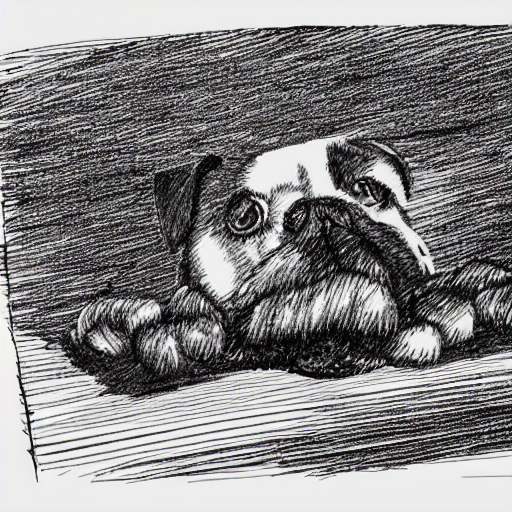

In [6]:
def DeforumArgs():

    #@markdown **Image Settings**
    W = 512 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'klms' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim"]
    steps = 50 #@param
    scale = 7 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    batch_name = "StableFun" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random"]
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.0 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}

    n_samples = 1 # doesnt do anything
    precision = 'autocast' 
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_c = None

    return locals()



def next_seed(args):
    if args.seed_behavior == 'iter':
        args.seed += 1
    elif args.seed_behavior == 'fixed':
        pass # always keep seed the same
    else:
        args.seed = random.randint(0, 2**32 - 1)
    return args.seed

def render_image_batch(args):
    args.prompts = {k: f"{v:05d}" for v, k in enumerate(prompts)}
    
    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    if args.save_settings or args.save_samples:
        print(f"Saving to {os.path.join(args.outdir, args.timestring)}_*")

    # save settings for the batch
    if args.save_settings:
        filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
        with open(filename, "w+", encoding="utf-8") as f:
            json.dump(dict(args.__dict__), f, ensure_ascii=False, indent=4)

    index = 0
    
    # function for init image batching
    init_array = []
    if args.use_init:
        if args.init_image == "":
            raise FileNotFoundError("No path was given for init_image")
        if args.init_image.startswith('http://') or args.init_image.startswith('https://'):
            init_array.append(args.init_image)
        elif not os.path.isfile(args.init_image):
            if args.init_image[-1] != "/": # avoids path error by adding / to end if not there
                args.init_image += "/" 
            for image in sorted(os.listdir(args.init_image)): # iterates dir and appends images to init_array
                if image.split(".")[-1] in ("png", "jpg", "jpeg"):
                    init_array.append(args.init_image + image)
        else:
            init_array.append(args.init_image)
    else:
        init_array = [""]

    # when doing large batches don't flood browser with images
    clear_between_batches = args.n_batch >= 32

    for iprompt, prompt in enumerate(prompts):  
        args.prompt = prompt
        print(f"Prompt {iprompt+1} of {len(prompts)}")
        print(f"{args.prompt}")

        all_images = []

        for batch_index in range(args.n_batch):
            if clear_between_batches and batch_index % 32 == 0: 
                display.clear_output(wait=True)            
            print(f"Batch {batch_index+1} of {args.n_batch}")
            
            for image in init_array: # iterates the init images
                args.init_image = image
                results = generate(args)
                for image in results:
                    if args.make_grid:
                        all_images.append(T.functional.pil_to_tensor(image))
                    if args.save_samples:
                        if args.filename_format == "{timestring}_{index}_{prompt}.png":
                            filename = f"{args.timestring}_{index:05}_{sanitize(prompt)[:160]}.png"
                        else:
                            filename = f"{args.timestring}_{index:05}_{args.seed}.png"
                        image.save(os.path.join(args.outdir, filename))
                    if args.display_samples:
                        display.display(image)
                    index += 1
                args.seed = next_seed(args)

        #print(len(all_images))
        if args.make_grid:
            grid = make_grid(all_images, nrow=int(len(all_images)/args.grid_rows))
            grid = rearrange(grid, 'c h w -> h w c').cpu().numpy()
            filename = f"{args.timestring}_{iprompt:05d}_grid_{args.seed}.png"
            grid_image = Image.fromarray(grid.astype(np.uint8))
            grid_image.save(os.path.join(args.outdir, filename))
            display.clear_output(wait=True)            
            display.display(grid_image)


def render_animation(args, anim_args):
    # animations use key framed prompts
    args.prompts = animation_prompts

    # expand key frame strings to values
    keys = DeformAnimKeys(anim_args)

    # resume animation
    start_frame = 0
    if anim_args.resume_from_timestring:
        for tmp in os.listdir(args.outdir):
            if tmp.split("_")[0] == anim_args.resume_timestring:
                start_frame += 1
        start_frame = start_frame - 1

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    print(f"Saving animation frames to {args.outdir}")

    # save settings for the batch
    settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
    with open(settings_filename, "w+", encoding="utf-8") as f:
        s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
        json.dump(s, f, ensure_ascii=False, indent=4)
        
    # resume from timestring
    if anim_args.resume_from_timestring:
        args.timestring = anim_args.resume_timestring

    # expand prompts out to per-frame
    prompt_series = pd.Series([np.nan for a in range(anim_args.max_frames)])
    for i, prompt in animation_prompts.items():
        prompt_series[i] = prompt
    prompt_series = prompt_series.ffill().bfill()

    # check for video inits
    using_vid_init = anim_args.animation_mode == 'Video Input'

    # load depth model for 3D
    predict_depths = (anim_args.animation_mode == '3D' and anim_args.use_depth_warping) or anim_args.save_depth_maps
    if predict_depths:
        depth_model = DepthModel(device)
        depth_model.load_midas(models_path)
        if anim_args.midas_weight < 1.0:
            depth_model.load_adabins()
    else:
        depth_model = None
        anim_args.save_depth_maps = False

    # state for interpolating between diffusion steps
    turbo_steps = 1 if using_vid_init else int(anim_args.diffusion_cadence)
    turbo_prev_image, turbo_prev_frame_idx = None, 0
    turbo_next_image, turbo_next_frame_idx = None, 0

    # resume animation
    prev_sample = None
    color_match_sample = None
    if anim_args.resume_from_timestring:
        last_frame = start_frame-1
        if turbo_steps > 1:
            last_frame -= last_frame%turbo_steps
        path = os.path.join(args.outdir,f"{args.timestring}_{last_frame:05}.png")
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        prev_sample = sample_from_cv2(img)
        if anim_args.color_coherence != 'None':
            color_match_sample = img
        if turbo_steps > 1:
            turbo_next_image, turbo_next_frame_idx = sample_to_cv2(prev_sample, type=np.float32), last_frame
            turbo_prev_image, turbo_prev_frame_idx = turbo_next_image, turbo_next_frame_idx
            start_frame = last_frame+turbo_steps

    args.n_samples = 1
    frame_idx = start_frame
    while frame_idx < anim_args.max_frames:
        print(f"Rendering animation frame {frame_idx} of {anim_args.max_frames}")
        noise = keys.noise_schedule_series[frame_idx]
        strength = keys.strength_schedule_series[frame_idx]
        contrast = keys.contrast_schedule_series[frame_idx]
        depth = None
        
        # emit in-between frames
        if turbo_steps > 1:
            tween_frame_start_idx = max(0, frame_idx-turbo_steps)
            for tween_frame_idx in range(tween_frame_start_idx, frame_idx):
                tween = float(tween_frame_idx - tween_frame_start_idx + 1) / float(frame_idx - tween_frame_start_idx)
                print(f"  creating in between frame {tween_frame_idx} tween:{tween:0.2f}")

                advance_prev = turbo_prev_image is not None and tween_frame_idx > turbo_prev_frame_idx
                advance_next = tween_frame_idx > turbo_next_frame_idx

                if depth_model is not None:
                    assert(turbo_next_image is not None)
                    depth = depth_model.predict(turbo_next_image, anim_args)

                if anim_args.animation_mode == '2D':
                    if advance_prev:
                        turbo_prev_image = anim_frame_warp_2d(turbo_prev_image, args, anim_args, keys, tween_frame_idx)
                    if advance_next:
                        turbo_next_image = anim_frame_warp_2d(turbo_next_image, args, anim_args, keys, tween_frame_idx)
                else: # '3D'
                    if advance_prev:
                        turbo_prev_image = anim_frame_warp_3d(turbo_prev_image, depth, anim_args, keys, tween_frame_idx)
                    if advance_next:
                        turbo_next_image = anim_frame_warp_3d(turbo_next_image, depth, anim_args, keys, tween_frame_idx)
                turbo_prev_frame_idx = turbo_next_frame_idx = tween_frame_idx

                if turbo_prev_image is not None and tween < 1.0:
                    img = turbo_prev_image*(1.0-tween) + turbo_next_image*tween
                else:
                    img = turbo_next_image

                filename = f"{args.timestring}_{tween_frame_idx:05}.png"
                cv2.imwrite(os.path.join(args.outdir, filename), cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR))
                if anim_args.save_depth_maps:
                    depth_model.save(os.path.join(args.outdir, f"{args.timestring}_depth_{tween_frame_idx:05}.png"), depth)
            if turbo_next_image is not None:
                prev_sample = sample_from_cv2(turbo_next_image)

        # apply transforms to previous frame
        if prev_sample is not None:
            if anim_args.animation_mode == '2D':
                prev_img = anim_frame_warp_2d(sample_to_cv2(prev_sample), args, anim_args, keys, frame_idx)
            else: # '3D'
                prev_img_cv2 = sample_to_cv2(prev_sample)
                depth = depth_model.predict(prev_img_cv2, anim_args) if depth_model else None
                prev_img = anim_frame_warp_3d(prev_img_cv2, depth, anim_args, keys, frame_idx)

            # apply color matching
            if anim_args.color_coherence != 'None':
                if color_match_sample is None:
                    color_match_sample = prev_img.copy()
                else:
                    prev_img = maintain_colors(prev_img, color_match_sample, anim_args.color_coherence)

            # apply scaling
            contrast_sample = prev_img * contrast
            # apply frame noising
            noised_sample = add_noise(sample_from_cv2(contrast_sample), noise)

            # use transformed previous frame as init for current
            args.use_init = True
            if half_precision:
                args.init_sample = noised_sample.half().to(device)
            else:
                args.init_sample = noised_sample.to(device)
            args.strength = max(0.0, min(1.0, strength))

        # grab prompt for current frame
        args.prompt = prompt_series[frame_idx]
        print(f"{args.prompt} {args.seed}")

        # grab init image for current frame
        if using_vid_init:
            init_frame = os.path.join(args.outdir, 'inputframes', f"{frame_idx+1:04}.jpg")            
            print(f"Using video init frame {init_frame}")
            args.init_image = init_frame

        # sample the diffusion model
        sample, image = generate(args, return_latent=False, return_sample=True)
        if not using_vid_init:
            prev_sample = sample

        if turbo_steps > 1:
            turbo_prev_image, turbo_prev_frame_idx = turbo_next_image, turbo_next_frame_idx
            turbo_next_image, turbo_next_frame_idx = sample_to_cv2(sample, type=np.float32), frame_idx
            frame_idx += turbo_steps
        else:    
            filename = f"{args.timestring}_{frame_idx:05}.png"
            image.save(os.path.join(args.outdir, filename))
            if anim_args.save_depth_maps:
                if depth is None:
                    depth = depth_model.predict(sample_to_cv2(sample), anim_args)
                depth_model.save(os.path.join(args.outdir, f"{args.timestring}_depth_{frame_idx:05}.png"), depth)
            frame_idx += 1

        display.clear_output(wait=True)
        display.display(image)

        args.seed = next_seed(args)

def render_input_video(args, anim_args):
    # create a folder for the video input frames to live in
    video_in_frame_path = os.path.join(args.outdir, 'inputframes') 
    os.makedirs(video_in_frame_path, exist_ok=True)
    
    # save the video frames from input video
    print(f"Exporting Video Frames (1 every {anim_args.extract_nth_frame}) frames to {video_in_frame_path}...")
    try:
        for f in pathlib.Path(video_in_frame_path).glob('*.jpg'):
            f.unlink()
    except:
        pass
    vf = r'select=not(mod(n\,'+str(anim_args.extract_nth_frame)+'))'
    subprocess.run([
        'ffmpeg', '-i', f'{anim_args.video_init_path}', 
        '-vf', f'{vf}', '-vsync', 'vfr', '-q:v', '2', 
        '-loglevel', 'error', '-stats',  
        os.path.join(video_in_frame_path, '%04d.jpg')
    ], stdout=subprocess.PIPE).stdout.decode('utf-8')

    # determine max frames from length of input frames
    anim_args.max_frames = len([f for f in pathlib.Path(video_in_frame_path).glob('*.jpg')])

    args.use_init = True
    print(f"Loading {anim_args.max_frames} input frames from {video_in_frame_path} and saving video frames to {args.outdir}")
    render_animation(args, anim_args)

def render_interpolation(args, anim_args):
    # animations use key framed prompts
    args.prompts = animation_prompts

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    print(f"Saving animation frames to {args.outdir}")

    # save settings for the batch
    settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
    with open(settings_filename, "w+", encoding="utf-8") as f:
        s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
        json.dump(s, f, ensure_ascii=False, indent=4)
    
    # Interpolation Settings
    args.n_samples = 1
    args.seed_behavior = 'fixed' # force fix seed at the moment bc only 1 seed is available
    prompts_c_s = [] # cache all the text embeddings

    print(f"Preparing for interpolation of the following...")

    for i, prompt in animation_prompts.items():
      args.prompt = prompt

      # sample the diffusion model
      results = generate(args, return_c=True)
      c, image = results[0], results[1]
      prompts_c_s.append(c) 
      
      # display.clear_output(wait=True)
      display.display(image)
      
      args.seed = next_seed(args)

    display.clear_output(wait=True)
    print(f"Interpolation start...")

    frame_idx = 0

    if anim_args.interpolate_key_frames:
      for i in range(len(prompts_c_s)-1):
        dist_frames = list(animation_prompts.items())[i+1][0] - list(animation_prompts.items())[i][0]
        if dist_frames <= 0:
          print("key frames duplicated or reversed. interpolation skipped.")
          return
        else:
          for j in range(dist_frames):
            # interpolate the text embedding
            prompt1_c = prompts_c_s[i]
            prompt2_c = prompts_c_s[i+1]  
            args.init_c = prompt1_c.add(prompt2_c.sub(prompt1_c).mul(j * 1/dist_frames))

            # sample the diffusion model
            results = generate(args)
            image = results[0]

            filename = f"{args.timestring}_{frame_idx:05}.png"
            image.save(os.path.join(args.outdir, filename))
            frame_idx += 1

            display.clear_output(wait=True)
            display.display(image)

            args.seed = next_seed(args)

    else:
      for i in range(len(prompts_c_s)-1):
        for j in range(anim_args.interpolate_x_frames+1):
          # interpolate the text embedding
          prompt1_c = prompts_c_s[i]
          prompt2_c = prompts_c_s[i+1]  
          args.init_c = prompt1_c.add(prompt2_c.sub(prompt1_c).mul(j * 1/(anim_args.interpolate_x_frames+1)))

          # sample the diffusion model
          results = generate(args)
          image = results[0]

          filename = f"{args.timestring}_{frame_idx:05}.png"
          image.save(os.path.join(args.outdir, filename))
          frame_idx += 1

          display.clear_output(wait=True)
          display.display(image)

          args.seed = next_seed(args)

    # generate the last prompt
    args.init_c = prompts_c_s[-1]
    results = generate(args)
    image = results[0]
    filename = f"{args.timestring}_{frame_idx:05}.png"
    image.save(os.path.join(args.outdir, filename))

    display.clear_output(wait=True)
    display.display(image)
    args.seed = next_seed(args)

    #clear init_c
    args.init_c = None


args = SimpleNamespace(**DeforumArgs())
anim_args = SimpleNamespace(**DeforumAnimArgs())

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(args, anim_args)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(args, anim_args)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(args, anim_args)
else:
    render_image_batch(args)    

# Create video from frames

In [7]:
skip_video_for_run_all = True #@param {type: 'boolean'}
fps = 12 #@param {type:"number"}
#@markdown **Manual Settings**
use_manual_settings = False #@param {type:"boolean"}
image_path = "/content/drive/MyDrive/AI/StableDiffusion/2022-09/20220903000939_%05d.png" #@param {type:"string"}
mp4_path = "/content/drive/MyDrive/AI/StableDiffusion/2022-09/20220903000939.mp4" #@param {type:"string"}


if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:
    import os
    import subprocess
    from base64 import b64encode

    print(f"{image_path} -> {mp4_path}")

    if use_manual_settings:
        max_frames = "200" #@param {type:"string"}
    else:
        image_path = os.path.join(args.outdir, f"{args.timestring}_%05d.png")
        mp4_path = os.path.join(args.outdir, f"{args.timestring}.mp4")
        max_frames = str(anim_args.max_frames)

    # make video
    cmd = [
        'ffmpeg',
        '-y',
        '-vcodec', 'png',
        '-r', str(fps),
        '-start_number', str(0),
        '-i', image_path,
        '-frames:v', max_frames,
        '-c:v', 'libx264',
        '-vf',
        f'fps={fps}',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',
        '-preset', 'veryfast',
        mp4_path
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        raise RuntimeError(stderr)

    mp4 = open(mp4_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display( display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )

Skipping video creation, uncheck skip_video_for_run_all if you want to run it
